##### Описание:
Классифицировать игроков в каждом кадре по двум командам на основе цвета их формы.

### Данные:
Скачайте архив с данными [отсюда](https://disk.yandex.ru/d/NMlVHytktlzbEw) и распакуйте. Внутри архива лежит папка `frames` и файл `bboxes.json`. Файл `bboxes.json` содержит bounding boxes игроков двух команд, а в папке `frames` расположены соответствующие им изображения (кадры). Всего дано 100 кадров. Каждому кадру соответствует 10 bounding boxes игроков.

Структура файла `bboxes.json` следующая:
```
frame_n: {
     player_1: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
     plyaer_10: { .... }
}
....
frame_n+k: { .... }
```
Здесь `frame_n` - номер кадра (ему соответствует файл с изображением в папке frames, всего 100),<br>
`player_1` - id игрока в текущем кадре,<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).
Такм образом, id игроков и id команд имеют смысл только в пределах одного кадра и не связаны с другими кадрами. Т.е. в разных кадрах одному и тому же игроку / команде может соответствовать разные id.

### Задачи:
1) Классифицируйте игроков, используя в качестве вектора признаков игрока (features) средний цвет в пространстве RGB, который берется из области изображения, покрытой bounding box этого игрока (т.е. вектор признаков будет состоять из 3 элементов `[r,g,b]`.<br>
2) Используйте в качестве вектора признаков игроков их средний цвет в пространстве HSV (аналогично вектор признаков `[h,s,v]`.<br>
3) Используйте в качестве вектора признаков гистограмму в пространстве RGB, а не средний цвет. Число бинов определите самостоятельно.<br>
4) Используйте в качестве вектора признаков гистограмму в пространстве HSV.

### Как классифицировать:
В качестве классификатора можете использовать:
- Методы без обучения: k-means (на 2 кластера) или другие методы кластеризации.
- Методы с обучением: K-Nearest Neighbors, RandomForest, GaussianNB или др.

### Результаты:
1. Посчитайте точность классификации для каждого варианта и сравните результаты. 
2. Задание будет принято, если итоговая точность будет выше чем 0.5
3. [опционально] При тестировании на закрытой выборке в конце курса будет подведен итог (рекорд по всем курсам на данный момент - ***0.953***).

#### Полезные советы
- Боксы игроков имеют разный размер, поэтому нормализуйте гистограмму перед ее использованием в качестве вектора признаков (делите значения гистограммы на площадь бокса). 
- Большое число бинов гистограммы может привести к худшим результатам, поэтому попробуйте использовать 8/16/32.
- Для построения вектора признаков лучше использовать некоторую его центральную область, т.к. она покрывает игрока, а границы часто содержут фон / других игроков.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster as sk
import cv2
import json
import os

# Обьявление функций и подготовка данных

In [33]:
# Распарсить json-файла
def parsing_json(json_file):
    # Загрузил json
    with open(json_file, 'r') as file:
        data = json.load(file)

        # Перевод в int номер кадра и номер игрока
        data = {
            int(frame_id): {
                int(player_id): info
                for player_id, info in player_id.items()
            }
        for frame_id, player_id in data.items()
        }

        # Перевод bounding_box в [x_min, y_min, w, h]
        for frame_id in data:
            for player_id in data[frame_id]:
                frame = cv2.imread(f'team_classification_data/frames/{frame_id}.jpeg',-1)
                
                x = data[frame_id][player_id]['box'][0] * frame.shape[1]
                y = data[frame_id][player_id]['box'][1] * frame.shape[0]
                w = data[frame_id][player_id]['box'][2] * frame.shape[1]
                h = data[frame_id][player_id]['box'][3] * frame.shape[0]

                data[frame_id][player_id]['box'][0] = int(round(x))
                data[frame_id][player_id]['box'][1] = int(round(y))
                data[frame_id][player_id]['box'][2] = int(round(w))
                data[frame_id][player_id]['box'][3] = int(round(h))
    return data

def get_average_chanal_color(img):
    # Разделение на каналы
    сh1, сh2, сh3 = cv2.split(img)
    # Расчет средних значений
    avg_сh1, avg_сh2, avg_сh3 = np.mean(сh1), np.mean(сh2), np.mean(сh3)
    avg_color = [avg_сh1, avg_сh2, avg_сh3]
    return avg_color

def get_hsv_image_from_path(image_path):
    bgr_image = cv2.imread(image_path, -1)
    hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
    return hsv_image

def get_rbg_image_from_path(image_path):
    bgr_image = cv2.imread(image_path, -1)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

def crop_bounding_box(bbox, image):
    x, y, w, h = bbox
    # Выбираем серидину бб
    w_25 = int(w/4)
    h_25 = int(h/4)
    x = x + w_25
    y = y + h_25
    cropped_image = image[y:y + (h_25*2), x:x + (w_25*2)]
    return cropped_image

def extract_feature(frame_data, image):
    features = []
    for player_data in frame_data.values():
        bbox = player_data['box']
        # Обрезаем изображение по bounding box
        cropped_image = crop_bounding_box(bbox, image)
        # Вычисляем средний цвет
        avg_color = get_average_chanal_color(cropped_image)
        #print(avg_color)
        features.append(avg_color)
    return features

def compare(vec, gt):
    res = [1 if g in vec else 0 for g in gt]
    return res

def calc_accuracy(gt_dict, pred_dict):
    total_accuracy=0
    total_frames=0
    # Расчет точности классификатора
    for frame_id in gt_dict:
        # формируем списки сравнения
        gt_team0 = gt_dict[frame_id]['team_0']
        gt_team1 = gt_dict[frame_id]['team_1']
        pred_team0 = pred_dict[frame_id]['team_0']
        pred_team1 = pred_dict[frame_id]['team_1']
        # Расчет точности
        res0 = compare(pred_team0, gt_team0)
        res1 = compare(pred_team1, gt_team1)
        accuracy = sum(res0+res1) / len(gt_team0+gt_team1)
        # Меняем местами словари если не совпали при классификации
        if accuracy < 0.5:
            res0 = compare(pred_team0, gt_team1)
            res1 = compare(pred_team1, gt_team0)
            accuracy = sum(res0+res1) / len(gt_team0+gt_team1)
        # Сумма всех точностей по выборке
        total_accuracy+=accuracy
        total_frames+=1
    # Расчет средней точности по выборке
    avg_accuracy = (total_accuracy / total_frames)
    return round(avg_accuracy, 2)

def extract_features_hist(frame_data, image):
    features = []
    for player_data in frame_data.values():
        bbox = player_data['box']
        # Обрезаем изображение по bounding box
        cropped_image = crop_bounding_box(bbox, image)
        # Вычисляем средний цвет
        avg_color = get_rgb_average_histogram(cropped_image)
        #print(avg_color)
        features.append(avg_color)
    return features

def get_rgb_average_histogram(img):
    bins=8
    # Гистограмма для каждого канала
    hist_ch1 = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
    hist_ch2 = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_ch3 = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()
    # Нормализация
    hist_nch1 = cv2.normalize(hist_ch1, None).flatten()
    hist_nch2 = cv2.normalize(hist_ch2, None).flatten()
    hist_nch3 = cv2.normalize(hist_ch3, None).flatten()
    return np.concatenate([hist_nch1, hist_nch2, hist_nch3])

In [4]:
# Получение данных для обработки
data = parsing_json('team_classification_data/bboxes.json')

### Проверка на коректность выбора bounding box

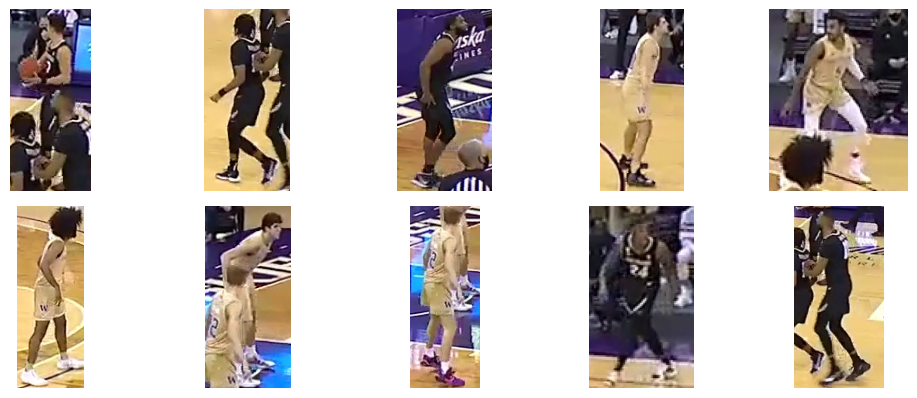

In [5]:
frame = 25813 # фрейм из выборки
img = cv2.imread(f'team_classification_data/frames/{frame}.jpeg',-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))

for player_id in data[frame]:
    x_min = data[frame][player_id]['box'][0] # x
    y_min = data[frame][player_id]['box'][1] # y
    x_max = x_min + data[frame][player_id]['box'][2] # x+w
    y_max = y_min + data[frame][player_id]['box'][3] # y+h

    img_bbox = img[y_min:y_max, x_min:x_max]
    plt.subplot(5, 5, player_id+1)
    plt.imshow(img_bbox)
    plt.axis('off')

plt.tight_layout()
plt.show()

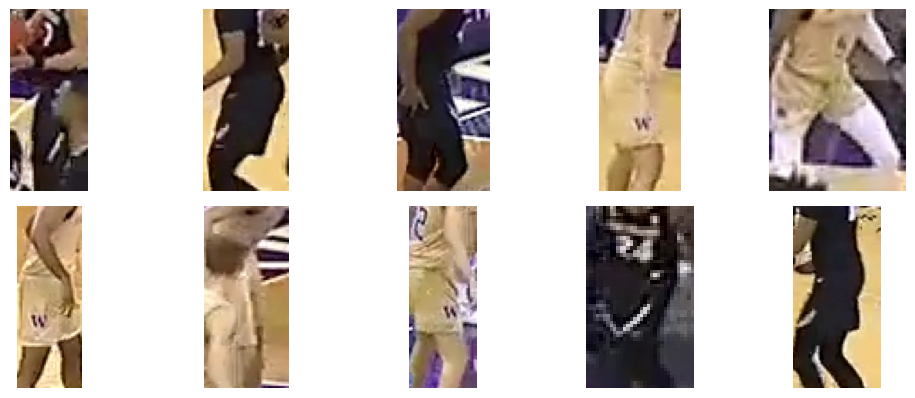

In [6]:
frame = 25813 # фрейм из выборки
img = cv2.imread(f'team_classification_data/frames/{frame}.jpeg',-1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))

for player_id in data[frame]:
    w_25 = int(data[frame][player_id]['box'][2]/4) # 25% ширины бб
    h_25 = int(data[frame][player_id]['box'][3]/4) # 25% высоты бб

    x_min = data[frame][player_id]['box'][0]+w_25 # x
    y_min = data[frame][player_id]['box'][1]+h_25 # y
    x_max = x_min + w_25*2
    y_max = y_min + h_25*2
    # x_max = x_min + data[frame][player_id]['box'][2] # x+w
    # y_max = y_min + data[frame][player_id]['box'][3] # y+h

    img_bbox = img[y_min:y_max, x_min:x_max]
    plt.subplot(5, 5, player_id+1)
    plt.imshow(img_bbox)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Задача №1,2,3,4

### Создание Ground True словаря

In [7]:
gt = {}

for frame_id, players in data.items():
    # Инициализируем структуру для текущего кадра
    gt[frame_id] = {"team_0": [], "team_1": []}
    # Распределяем игроков по командам
    for player_id, player_info in players.items():
        team = player_info["team"]
        team_key = f"team_{team}"
        gt[frame_id][team_key].append(player_id)
#print(gt)

### Получение вектора признаков

In [8]:
all_features_task_1 = [] # Вектор признаков для Задания №1
all_features_task_2 = [] # Вектор признаков для Задания №2
all_features_task_3 = [] # Вектор признаков для Задания №3
all_features_task_4 = [] # Вектор признаков для Задания №4

# Извлечение вектора признаков из bounding box`в всех фреймов
for frame_id, frame_data in data.items():
    image_path = f'team_classification_data/frames/{frame_id}.jpeg'
    features_rgb = [] # Вектор текущего кадра Задание №1
    features_hsv = [] # Вектор текущего кадра Задание №2
    features_rgb_hist = [] # Вектор текущего кадра Задание №3
    features_hsv_hist = [] # Вектор текущего кадра Задание №4
    
    # Текущий кадр из выборки Задание №1,3
    image_rgb = get_rbg_image_from_path(image_path)
    # Текущий кадр из выборки Задание №2,4
    image_hsv = get_hsv_image_from_path(image_path)

    # Получаю вектор-признаков Задание №1
    features_rgb = extract_feature(frame_data, image_rgb)
    # Получаю вектор-признаков Задание №2
    features_hsv = extract_feature(frame_data, image_hsv)
    # Получаю вектор-признаков Задание №3
    features_rgb_hist = extract_features_hist(frame_data, image_rgb)
    # Получаю вектор-признаков Задание №4  
    features_hsv_hist = extract_features_hist(frame_data, image_hsv)

    # Добавляю в общий список векторов-признаков по каждому заданию
    all_features_task_1.extend(features_rgb)
    all_features_task_2.extend(features_hsv)
    all_features_task_3.extend(features_rgb_hist)
    all_features_task_4.extend(features_hsv_hist)

#print(all_features_task_1)
#print(all_features_task_2)
#print(all_features_task_3)
#print(all_features_task_4)


### Обучение моделей

In [ ]:
labels_1 = [] # Оценка модели №1
labels_2 = [] # Оценка модели №2
labels_3 = [] # Оценка модели №3
labels_4 = [] # Оценка модели №4

# Модель задания №1
kmeans_1 = sk.KMeans(n_clusters=2)
kmeans_1.fit(all_features_task_1)
for i in range(0, len(kmeans_1.labels_), 10):
    labels_1.append(kmeans_1.labels_[i:i+10])

# Модель задания №2
kmeans_2 = sk.KMeans(n_clusters=2)
kmeans_2.fit(all_features_task_2)
for i in range(0, len(kmeans_2.labels_), 10):
    labels_2.append(kmeans_2.labels_[i:i+10])

# Модель задания №3
kmeans_3 = sk.KMeans(n_clusters=2)
kmeans_3.fit(all_features_task_3)
for i in range(0, len(kmeans_3.labels_), 10):
    labels_3.append(kmeans_3.labels_[i:i+10])

# Модель задания №2
kmeans_4 = sk.KMeans(n_clusters=2)
kmeans_4.fit(all_features_task_4)
for i in range(0, len(kmeans_4.labels_), 10):
    labels_4.append(kmeans_4.labels_[i:i+10])

# print(labels_1)
# print(labels_2)
# print(labels_3)
# print(labels_4)

[array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0], dtype=int32), array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0], dtype=int32), array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1], dtype=int32), array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int32), array([1, 1, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int32), array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1], dtype=int32), array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0], dtype=int32), array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0], dtype=int32), array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0], dtype=int32), array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32), array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0], dtype=int32), array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32), array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0], dtype=int32), array([0, 1, 1, 1, 0, 0, 1, 0, 0, 1], dtype=int32), array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int32), array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1], dtype=int32), array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1], dtype=int32), array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int32), array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0], dtype=int32), array([0, 0

### Создание Predicted словаря

In [ ]:
predicted_1 = {}
predicted_2 = {}
predicted_3 = {}
predicted_4 = {}
index = 0

# Проход по всей выборке
for frame_id, players in data.items():
    # Инициализируем структуру для текущего кадра
    predicted_1[frame_id] = {"team_0": [], "team_1": []}
    predicted_2[frame_id] = {"team_0": [], "team_1": []}
    predicted_3[frame_id] = {"team_0": [], "team_1": []}
    predicted_4[frame_id] = {"team_0": [], "team_1": []}
    # Распределение игроков по командам для модели №1
    for i in players:
        # Модель №1
        team_1 = labels_1[index][i]
        team_key_1 = f"team_{team_1}"
        predicted_1[frame_id][team_key_1].append(i)
        #М одель №2
        team_2 = labels_2[index][i]
        team_key_2 = f"team_{team_2}"
        predicted_2[frame_id][team_key_2].append(i)
        # Модель №3
        team_3 = labels_3[index][i]
        team_key_3 = f"team_{team_3}"
        predicted_3[frame_id][team_key_3].append(i)
        # Модель №4
        team_4 = labels_4[index][i]
        team_key_4 = f"team_{team_4}"
        predicted_4[frame_id][team_key_4].append(i)
    index+=1    
    
# print(predicted_1)
# print(predicted_2)
# print(predicted_3)
# print(predicted_4)

{1310: {'team_0': [3, 5, 6, 8, 9], 'team_1': [0, 1, 2, 4, 7]}, 1577: {'team_0': [2, 5, 8, 9], 'team_1': [0, 1, 3, 4, 6, 7]}, 2306: {'team_0': [1, 3, 5, 6], 'team_1': [0, 2, 4, 7, 8, 9]}, 2825: {'team_0': [0, 2, 4, 5, 7, 9], 'team_1': [1, 3, 6, 8]}, 3155: {'team_0': [2, 3, 5, 7, 8], 'team_1': [0, 1, 4, 6, 9]}, 5756: {'team_0': [0, 1, 3, 8], 'team_1': [2, 4, 5, 6, 7, 9]}, 5820: {'team_0': [0, 5, 7, 8, 9], 'team_1': [1, 2, 3, 4, 6]}, 6123: {'team_0': [2, 4, 7, 8, 9], 'team_1': [0, 1, 3, 5, 6]}, 6130: {'team_0': [2, 4, 7, 8, 9], 'team_1': [0, 1, 3, 5, 6]}, 6180: {'team_0': [2, 3, 4, 5, 7, 8, 9], 'team_1': [0, 1, 6]}, 7486: {'team_0': [1, 3, 6, 8, 9], 'team_1': [0, 2, 4, 5, 7]}, 14063: {'team_0': [8, 9], 'team_1': [0, 1, 2, 3, 4, 5, 6, 7]}, 16117: {'team_0': [1, 7, 8, 9], 'team_1': [0, 2, 3, 4, 5, 6]}, 19500: {'team_0': [0, 4, 5, 7, 8], 'team_1': [1, 2, 3, 6, 9]}, 21728: {'team_0': [1, 2, 3, 4, 5, 8, 9], 'team_1': [0, 6, 7]}, 21775: {'team_0': [1, 2, 5, 6, 8], 'team_1': [0, 3, 4, 7, 9]}, 22

### Рачет accuracy

In [34]:
# gt - cловарь GroundTrue, 
# predicted - словарь Классификатора

# Точность модели №1 (Задание №1)
avg_rgb_accuracy = calc_accuracy(gt, predicted_1)
print('AVG_RGB Accuracy:', avg_rgb_accuracy)
# Точность модели №2 (Задание №2)
avg_hsv_accuracy = calc_accuracy(gt, predicted_2)
print('AVG_HSV Accuracy:', avg_hsv_accuracy)
# Точность модели №3 (Задание №3)
avg_rgb_hist_accuracy = calc_accuracy(gt, predicted_3)
print('AVG_RGB_HIST Accuracy:', avg_rgb_hist_accuracy)
# Точность модели №4 (Задание №4)
avg_hsv_hist_accuracy = calc_accuracy(gt, predicted_4)
print('AVG_HSV_HIST Accuracy:', avg_hsv_hist_accuracy)

AVG_RGB Accuracy: 0.88
AVG_HSV Accuracy: 0.87
AVG_RGB_HIST Accuracy: 0.91
AVG_HSV_HIST Accuracy: 0.89


### Визуализация результатов

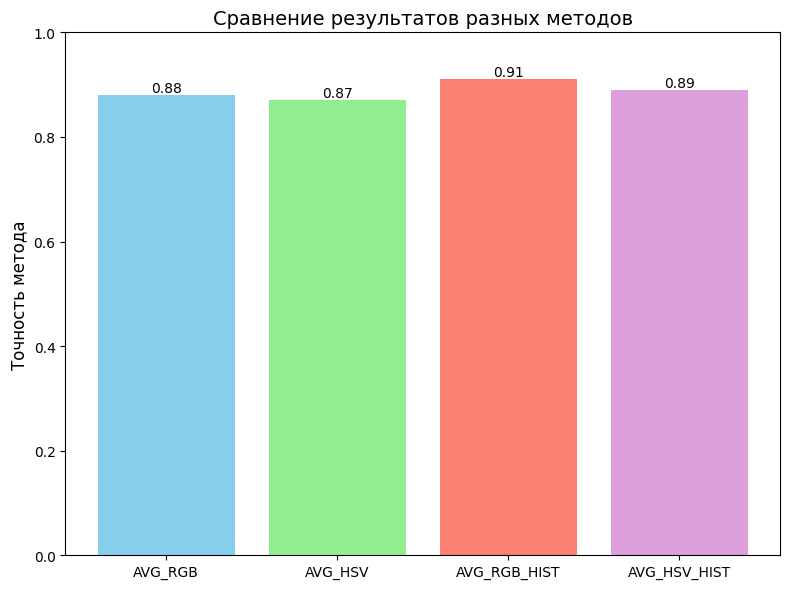

In [44]:
# Данные
methods = ['AVG_RGB', 'AVG_HSV', 'AVG_RGB_HIST', 'AVG_HSV_HIST']
accuracy = [avg_rgb_accuracy, avg_hsv_accuracy, avg_rgb_hist_accuracy, avg_hsv_hist_accuracy]

# Создание гистограммы
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, accuracy, color=['skyblue', 'lightgreen', 'salmon', 'plum'])

# Настройка осей и заголовка
plt.ylim(0, 1)
plt.ylabel('Точность метода', fontsize=12)
plt.title('Сравнение результатов разных методов', fontsize=14)

# Добавление значений на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Отображение графика
#plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()